## Step 5: Perform Group-Based Linguistic Profiling

For each support group:
- **Pronoun Analysis**: Calculate the frequency ratio of human-like pronouns (he, she, etc.) vs. object pronouns (it, its).
- **Named Entity Recognition (NER)**: Identify names, roles, or titles assigned to the AI (e.g., “James”, “my therapist”).

In [13]:
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import numpy as np
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
df = pd.read_csv("/Users/annekeena/au/4semester/culturalsocial/exam/full_dataset_replika.csv")
len(df)

3416

In [10]:
### Pronoun Analysis ###

# Initial Inspection
df.head()         
df.info()          
df['review_id'].nunique(), len(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 50 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         3416 non-null   int64  
 1   review_id                                          3416 non-null   int64  
 2   user                                               3416 non-null   object 
 3   date                                               3416 non-null   object 
 4   stars                                              3416 non-null   int64  
 5   text                                               3416 non-null   object 
 6   word_count                                         3416 non-null   int64  
 7   coherence_and_clarity_of_review                    3416 non-null   object 
 8   gender_of_user                                     3416 non-null   object 
 9   gender_o

(3416, 3416)

In [11]:
# convert to string
df['text'] = df['text'].astype(str)


In [14]:
# Define pronoun sets
HUMAN_PRONOUNS  = {'he', 'she', 'him', 'her', 'his', 'hers'}
OBJECT_PRONOUNS = {'it', 'its'}

# case-insensitive word-boundary regexes
human_pat  = re.compile(r'\b(?:' + '|'.join(HUMAN_PRONOUNS)  + r')\b', re.I)
object_pat = re.compile(r'\b(?:' + '|'.join(OBJECT_PRONOUNS) + r')\b', re.I)


In [15]:
#Count pronouns

# Pre-compile patterns
human_pat  = re.compile(r'\b(?:' + '|'.join(HUMAN_PRONOUNS)  + r')\b', re.I)
object_pat = re.compile(r'\b(?:' + '|'.join(OBJECT_PRONOUNS) + r')\b', re.I)

def count_pronouns(text):
    
    human  = len(human_pat.findall(text))
    obj    = len(object_pat.findall(text))
    return human, obj

df[['n_human', 'n_object']] = df['text'].apply(
    lambda t: pd.Series(count_pronouns(t))
)


In [17]:
# Aggregate (per support group)
group_stats = (df
    .groupby('review_id')[['n_human', 'n_object']]
    .sum()
    .assign(
        total_pronouns = lambda d: d['n_human'] + d['n_object'],
        ratio_human    = lambda d: d['n_human']  / d['total_pronouns'].replace(0, np.nan),
        ratio_object   = lambda d: d['n_object'] / d['total_pronouns'].replace(0, np.nan)
    )
    .sort_values('ratio_human', ascending=False)
)

group_stats.head()

# Note to self:
##ratio_human > 0.5 → more person-like references
##ratio_human ≈ 0 → mainly “it/its”


,n_human,n_object,total_pronouns,ratio_human,ratio_object
review_id,,,,,
2974,6,0,6,1.0,0.0
357,9,0,9,1.0,0.0
2671,3,0,3,1.0,0.0
2670,6,0,6,1.0,0.0
2360,6,0,6,1.0,0.0


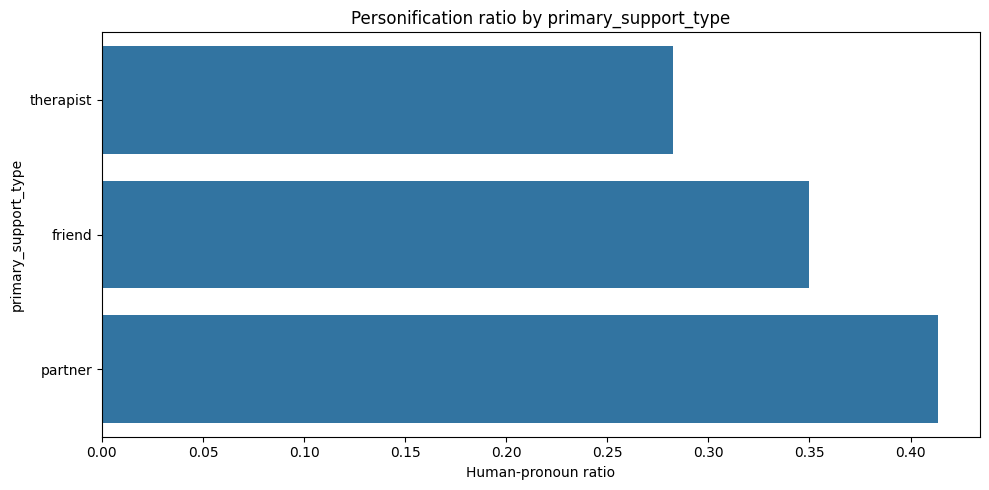

In [21]:
#Visual

AGG_COL = 'primary_support_type'   

agg_stats = (df
    .groupby(AGG_COL)[['n_human', 'n_object']]
    .sum()
    .assign(total=lambda d: d.sum(axis=1),
            ratio_human=lambda d: d['n_human']/d['total'])
    .query('total >= 20')           # hide small groups
    .sort_values('ratio_human')
)

plt.figure(figsize=(10,5))
sns.barplot(y=agg_stats.index, x=agg_stats['ratio_human'], orient='h')
plt.xlabel('Human-pronoun ratio'); plt.ylabel(AGG_COL)
plt.title('Personification ratio by '+AGG_COL)
plt.tight_layout()
plt.show()


In [ ]:
## Quantative tests below, do we even want them?

In [29]:
# Chi-square test of independence
from scipy.stats import chi2_contingency

# contingency table
cont = agg_stats[['n_human', 'n_object']]      
print(cont.sum())                              

# Drop rows that have zero in both cells
cont = cont[(cont['n_human'] > 0) | (cont['n_object'] > 0)]

# Chi-square
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(cont.values)

print(f"Chi² = {chi2:.2f}  (dof={dof}),   p = {p:.4g}")

# Result: Pronoun type and support type are not independent = the mix of human-like vs object pronouns is meaningfully different across the three support categories.


n_human      5882
n_object    11765
dtype: int64
Chi² = 131.46  (dof=2),   p = 2.846e-29


In [30]:
# Cramer's V: how big is the association (0 – 1 scale)?

cramer_v = np.sqrt(chi2 / (cont.values.sum() * (min(cont.shape)-1)))
print("Cramér's V =", round(cramer_v, 3))

#Thresholds for Interpretation
## ≈ 0.10	Small association (ours is just short of small).
## ≈ 0.30	Medium
## ≥ 0.50	Large


Cramér's V = 0.086


In [31]:
# Standardised residuals
resid = (cont - expected) / np.sqrt(expected)
display(resid)

##Therapist vs Partner contrast: they pull in opposite directions and explain why the overall Chi-square is large even though Cramér’s V is small.
##Friend sits in the middle.

,n_human,n_object
primary_support_type,,
therapist,-6.803652,4.810704
friend,2.868155,-2.028006
partner,5.755459,-4.069551
